In [1]:
import os
import sys
sys.path.append(os.path.abspath('..'))

In [26]:
import pandas as pd
import utils
import matplotlib.pyplot as plt
from active_learning import plotting, get_tracked_lineages_df

%config InlineBackend.figure_format = 'svg'

In [3]:
settings = utils.load_settings(path="../settings_sample.json")
cleaned_data_dir = settings["cleaned_data_dir"]
plots_dir = settings["plots_dir"]
reports_dir = settings["reports_dir"]
features_dir = settings["features_dir"]
start_date = settings["detection_start_date"]
n_days_delta = settings["detection_step"]

In [4]:
long_qs2_short = {
    "margin_sampling": "ms",
    "least_confident": "lc",
    "entropy": "en",
}

In [5]:
def get_model_detection_dates(feature:str, query_strategy:str, dump_dir:str):
    assert query_strategy in ['least_confident', 'margin_sampling', 'entropy'], f"Invalid query strategy: {query_strategy}"
    assert feature in ['kmer_5', 'kmer_6', 'kmer_7', 'kmer_8', 'fcgr_64', 'fcgr_128', 'murugaiah'], f"Invalid feature: {feature}"

    file_path = os.path.join(dump_dir, f'{feature}_detection_dates_{query_strategy}.tsv')
    if os.path.exists(file_path):
        model_dates = pd.read_csv(file_path, sep='\t')
        model_dates['model_date'] = pd.to_datetime(model_dates['model_date'])
        model_dates.rename(columns={'model_date': f'{feature}_{long_qs2_short[query_strategy]}'}, inplace=True)
        return model_dates
    else:
        print(f"File not found: {file_path}")

In [6]:
for file in os.listdir(reports_dir):
    if file.endswith('.tsv') and 'detection_dates' in file:
        keys = file.split('_detection_dates_')
        feature, query_strategy = keys[0], keys[1].split('.')[0]
        model_dates = get_model_detection_dates(feature, query_strategy, reports_dir)
        if model_dates is not None:
            if 'model_detection_dates_df' not in locals():
                model_detection_dates_df = model_dates
            else:
                model_detection_dates_df = model_detection_dates_df.merge(model_dates, on='lineage', how='outer')

In [7]:
df = pd.read_parquet(os.path.join(cleaned_data_dir, "cleaned_dataset.parquet"))
df.drop(columns=["Accession ID", "col_date", "sub_date", 'country'], inplace=True)

In [8]:
model_detection_dates_df

,lineage,kmer_7_lc,kmer_7_en,kmer_6_en,kmer_7_ms,kmer_6_lc,kmer_5_lc,kmer_5_en,kmer_6_ms,kmer_5_ms
0,B.1.1.7,2020-09-15,2020-09-15,2020-09-15,2020-09-20,2020-09-15,2020-09-15,2020-09-15,2020-09-20,2020-09-20
1,B.1.1.7.4,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,B.1.1.7.7,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,B.1.351,2020-05-23,2020-06-02,2020-05-23,2020-05-23,2020-05-23,2020-06-02,2020-06-02,2020-06-02,2020-08-11
4,B.1.351.2,2021-08-06,NaT,NaT,2021-01-08,NaT,NaT,NaT,2021-01-08,2021-01-08
...,...,...,...,...,...,...,...,...,...,...
229,B.1.526,NaT,2021-03-29,2021-03-29,NaT,NaT,NaT,2021-03-29,NaT,NaT
230,B.1.617.1,2021-03-19,2021-03-19,2021-03-19,2021-03-19,2021-03-19,2021-03-19,2021-03-19,2021-03-19,2021-03-19
231,B.1.617.3,2021-04-23,2021-04-23,2021-04-23,2021-04-23,2021-04-23,2021-04-23,2021-04-23,2021-04-23,2021-04-23
232,B.1.1.28.2,NaT,2021-01-18,2021-01-18,NaT,NaT,NaT,NaT,2021-02-27,2021-02-27


In [9]:
vois_df = get_tracked_lineages_df(df)
designation_dates = vois_df[['lineage', 'who_label', 'count', 'designation_date']]

In [10]:
merged_df = pd.merge(designation_dates, model_detection_dates_df, on='lineage', how='left')

In [11]:
merged_df

,lineage,who_label,count,designation_date,kmer_7_lc,kmer_7_en,kmer_6_en,kmer_7_ms,kmer_6_lc,kmer_5_lc,kmer_5_en,kmer_6_ms,kmer_5_ms
0,B.1.1.7,Alpha,2471,2020-12-29,2020-09-15,2020-09-15,2020-09-15,2020-09-20,2020-09-15,2020-09-15,2020-09-15,2020-09-20,2020-09-20
1,B.1.1.7.7,Alpha,1,2020-12-29,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,B.1.1.7.4,Alpha,4,2020-12-29,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,B.1.351,Beta,5330,2020-12-29,2020-05-23,2020-06-02,2020-05-23,2020-05-23,2020-05-23,2020-06-02,2020-06-02,2020-06-02,2020-08-11
4,B.1.351.2,Beta,1714,2020-12-29,2021-08-06,NaT,NaT,2021-01-08,NaT,NaT,NaT,2021-01-08,2021-01-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...
229,B.1.526,Iota,1,2021-02-26,NaT,2021-03-29,2021-03-29,NaT,NaT,NaT,2021-03-29,NaT,NaT
230,B.1.617.1,Kappa,5,2021-05-07,2021-03-19,2021-03-19,2021-03-19,2021-03-19,2021-03-19,2021-03-19,2021-03-19,2021-03-19,2021-03-19
231,B.1.617.3,N/A,4,2021-05-07,2021-04-23,2021-04-23,2021-04-23,2021-04-23,2021-04-23,2021-04-23,2021-04-23,2021-04-23,2021-04-23
232,B.1.1.28.2,Zeta,3,2021-02-26,NaT,2021-01-18,2021-01-18,NaT,NaT,NaT,NaT,2021-02-27,2021-02-27


In [29]:
merged_df.isnull().sum()

lineage              0
who_label            0
count                0
designation_date     0
kmer_7_lc           61
kmer_7_en           62
kmer_6_en           70
kmer_7_ms           58
kmer_6_lc           64
kmer_5_lc           67
kmer_5_en           70
kmer_6_ms           58
kmer_5_ms           58
dtype: int64

In [35]:
min_summary_merged_df = merged_df.groupby('who_label').agg({
    'designation_date': 'min',
    'kmer_7_lc': 'min',
    'kmer_7_en': 'min',
    'kmer_6_en': 'min',
    'kmer_7_ms': 'min',
    'kmer_6_lc': 'min',
    'kmer_5_lc': 'min',
    'kmer_5_en': 'min',
    'kmer_6_ms': 'min',
    'kmer_5_ms': 'min',
}).reset_index()

max_summary_merged_df = merged_df.groupby('who_label').agg({
    'designation_date': 'max',
    'kmer_7_lc': 'max',
    'kmer_7_en': 'max',
    'kmer_6_en': 'max',
    'kmer_7_ms': 'max',
    'kmer_6_lc': 'max',
    'kmer_5_lc': 'max',
    'kmer_5_en': 'max',
    'kmer_6_ms': 'max',
    'kmer_5_ms': 'max',
}).reset_index()

In [30]:
min_summary_merged_df

,who_label,designation_date,kmer_7_lc,kmer_7_en,kmer_6_en,kmer_7_ms,kmer_6_lc,kmer_5_lc,kmer_5_en,kmer_6_ms,kmer_5_ms
0,Alpha,2020-12-29,2020-09-15,2020-09-15,2020-09-15,2020-09-20,2020-09-15,2020-09-15,2020-09-15,2020-09-20,2020-09-20
1,Beta,2020-12-29,2020-05-23,2020-06-02,2020-05-23,2020-05-23,2020-05-23,2020-06-02,2020-06-02,2020-06-02,2020-08-11
2,Delta,2021-06-15,2020-06-17,2020-06-17,2020-06-17,2020-09-05,2020-06-17,2020-06-17,2020-06-17,2020-09-15,2020-09-05
3,Epsilon,2021-02-26,2021-02-02,2021-02-02,2021-02-02,NaT,2021-02-02,2021-02-02,2021-02-02,NaT,NaT
4,Eta,2021-02-26,2020-05-18,2020-05-18,2020-05-18,2020-05-18,2020-05-18,2020-05-18,2020-05-18,2020-05-28,2020-05-28
5,Gamma,2020-12-29,NaT,2021-03-19,2021-03-19,NaT,2021-03-19,2021-03-19,2021-03-19,2021-03-19,2021-03-19
6,Iota,2021-02-26,NaT,2021-03-29,2021-03-29,NaT,NaT,NaT,2021-03-29,NaT,NaT
7,Kappa,2021-05-07,2021-03-19,2021-03-19,2021-03-19,2021-03-19,2021-03-19,2021-03-19,2021-03-19,2021-03-19,2021-03-19
8,Mu,2021-09-21,NaT,2021-07-02,2021-07-02,NaT,NaT,NaT,2021-07-02,NaT,NaT
9,N/A,2021-05-07,2021-04-23,2021-04-23,2021-04-23,2021-04-23,2021-04-23,2021-04-23,2021-04-23,2021-04-23,2021-04-23


<Axes: >

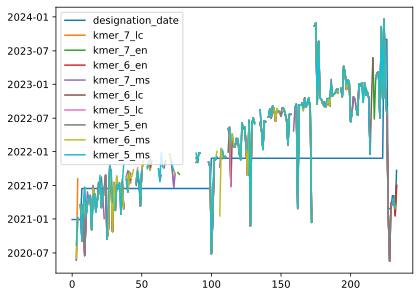

In [31]:
merged_df.drop(columns=['who_label', 'count']).plot()

In [23]:
min_summary_merged_df.isnull().sum()

who_label           0
designation_date    0
kmer_7_lc           4
kmer_7_en           0
kmer_6_en           0
kmer_7_ms           5
kmer_6_lc           3
kmer_5_lc           3
kmer_5_en           1
kmer_6_ms           3
kmer_5_ms           3
dtype: int64

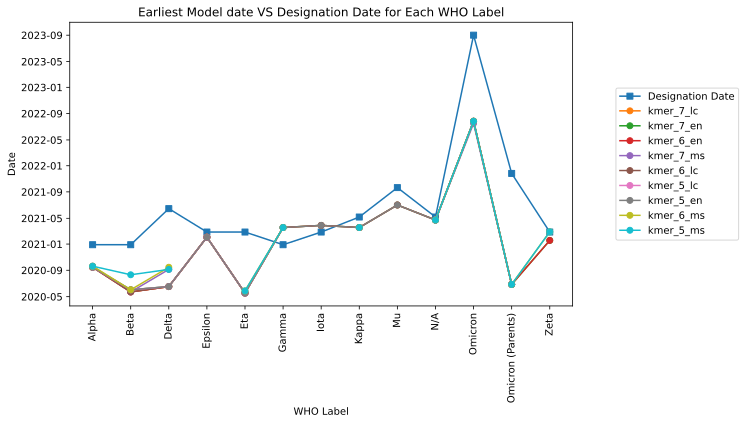

In [88]:
# Plotting
plt.figure(figsize=(11, 6))

plt.plot(min_summary_merged_df['who_label'], min_summary_merged_df['designation_date'], marker='s', linestyle='-', label='Designation Date')

for col in model_detection_dates_df.columns[1:]:
    plt.plot(min_summary_merged_df['who_label'], min_summary_merged_df[col], marker='o', linestyle='-', label=col)
    # plt.plot(max_summary_merged_df['who_label'], max_summary_merged_df[col], marker='*', linestyle='-', label=col)
    # plt.fill_between(min_summary_merged_df['who_label'], min_summary_merged_df[col], max_summary_merged_df[col], color='gray', alpha=0.15)

plt.xlabel('WHO Label')
plt.ylabel('Date')
plt.title('Earliest Model date VS Designation Date for Each WHO Label')
plt.xticks(rotation=90)

plt.legend(bbox_to_anchor = (1.34, 0.5), loc='center right')
plt.tight_layout()

plt.savefig(os.path.join(plots_dir, 'earliest_model_date_vs_designation_date.png'), dpi=300)

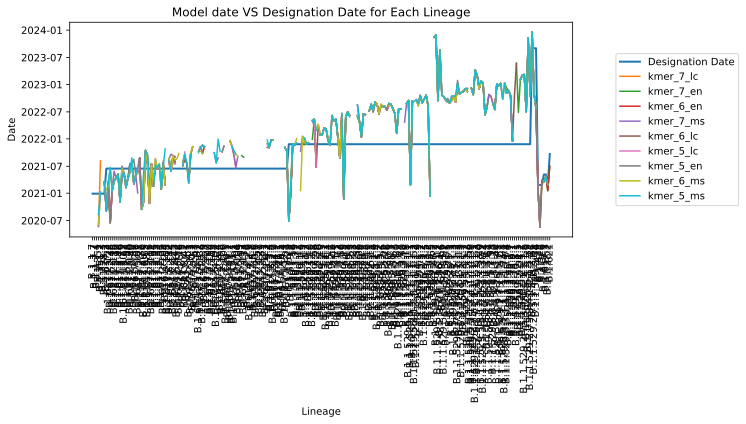

In [89]:
# Plotting
plt.figure(figsize=(11, 6))

plt.plot(merged_df['lineage'], merged_df['designation_date'], linestyle='-', label='Designation Date', linewidth=2)

for col in model_detection_dates_df.columns[1:]:
    plt.plot(merged_df['lineage'], merged_df[col], linestyle='-', label=col)
    # plt.plot(max_summary_merged_df['who_label'], max_summary_merged_df[col], marker='*', linestyle='-', label=col)
    # plt.fill_between(min_summary_merged_df['who_label'], min_summary_merged_df[col], max_summary_merged_df[col], color='gray', alpha=0.15)

plt.xlabel('Lineage')
plt.ylabel('Date')
plt.title('Model date VS Designation Date for Each Lineage')
plt.xticks(rotation=90)

plt.legend(bbox_to_anchor = (1.34, 0.5), loc='center right')
plt.tight_layout()

plt.savefig(os.path.join(plots_dir, 'model_date_vs_designation_date.png'), dpi=300)

In [25]:
min_summary_merged_df.to_excel(os.path.join(reports_dir, 'summary_model_detection_dates_vs_designation_dates.xlsx'), index=False)

In [14]:
merged_df.to_excel(os.path.join(reports_dir, 'model_detection_dates_vs_designation_dates.xlsx'), index=False)

In [36]:
lags_df = (merged_df['designation_date'] - merged_df['kmer_5_least_confident']).dt.days
lags_df

0      105.0
1        NaN
2        NaN
3      210.0
4        NaN
       ...  
229      NaN
230     49.0
231     14.0
232      NaN
233      NaN
Length: 234, dtype: float64

In [37]:
lags_df

count    167.000000
mean    -133.604790
std      225.902473
min     -733.000000
25%     -283.000000
50%     -152.000000
75%        2.000000
max      517.000000
dtype: float64

## Testing plotting and logger

In [43]:
# Summary statistics
mean_lag = df['Time Lag'].mean()
median_lag = df['Time Lag'].median()
std_lag = df['Time Lag'].std()

print(f"Mean Time Lag: {mean_lag} days")
print(f"Median Time Lag: {median_lag} days")
print(f"Standard Deviation: {std_lag} days")

Mean Time Lag: 0.6666666666666666 days
Median Time Lag: 2.0 days
Standard Deviation: 5.131601439446884 days


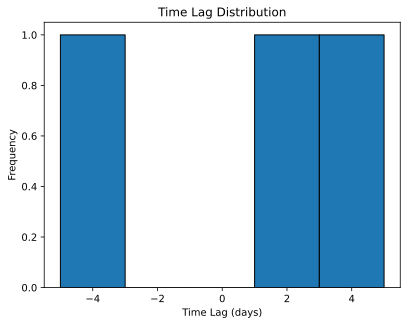

In [35]:
# Histogram
plotting.lags_histogram(
    lags=df['Time Lag'], 
    bins=5, 
    title='Time Lag Distribution', 
    xlabel='Time Lag (days)', 
    ylabel='Frequency',
    save=False,
)

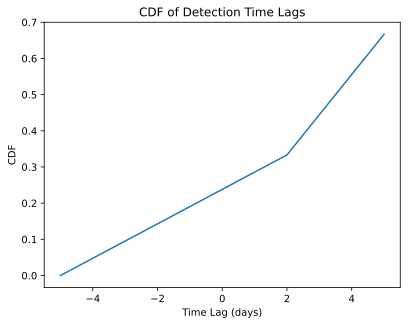

In [36]:
# CDF
plotting.lags_cdf(
    lags=df['Time Lag'], 
    title='CDF of Detection Time Lags', 
    xlabel='Time Lag (days)', 
    ylabel='CDF',
    save=False,
)

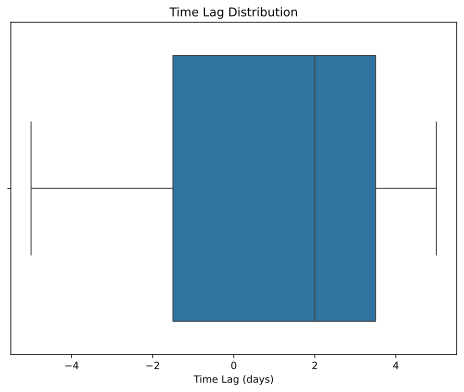

In [37]:
# Box Plot
plotting.lags_boxplot(
    lags=df['Time Lag'], 
    title='Time Lag Distribution', 
    xlabel='Time Lag (days)',
    save=False,
)

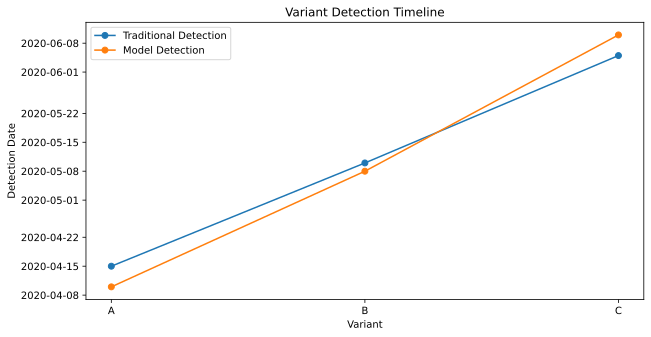

In [40]:
# Time Series Plot
plotting.variants_detection_timeline(
    variants=df['Variant'],
    traditional_detection=df['Traditional'],
    model_detection=df['Model'],
    save=False,
)